In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import unyt
import yt

from gasimage.utils.ray_plotting import \
    plot_projected_ray_path, plot_ray_and_projection


# When you start the tutorial, modify the variable to secify the path 
# where you put the downloaded (uncompressed_files)
_SAMPLE_DATA_DIR = "../test_data/"

_SIM_FNAME = (_SAMPLE_DATA_DIR + 
              "/X100_M1.5_HD_CDdftCstr_R56.38_logP3_Res8/"
              "cloud_07.5000/cloud_07.5000.block_list")

# Introduction

This is sort of WIP tutorial to getting started with this radiative transfer package...


## There are a couple prerequisites to handle:

1. Loading data
2. defining extra derived fields
3. specifying the rays to perform radiative transfer along

### Preqrequisite 1: Loading the data

This package builds on the `yt`-package. `yt` is primarily used for its ability to read in datasets.

In [2]:
ds = yt.load(_SIM_FNAME)

yt : [INFO     ] 2023-10-31 13:51:48,348 Parameters: current_time              = 7.5
yt : [INFO     ] 2023-10-31 13:51:48,350 Parameters: domain_dimensions         = [960 160 160]
yt : [INFO     ] 2023-10-31 13:51:48,351 Parameters: domain_left_edge          = [-60. -10. -10.]
yt : [INFO     ] 2023-10-31 13:51:48,353 Parameters: domain_right_edge         = [60. 10. 10.]
yt : [INFO     ] 2023-10-31 13:51:48,353 Parameters: cosmological_simulation   = 0


### Prerequisite 2: defining the necessary derived fields

We leverage `yt`'s derived field functionality to for intermediate calculations.

Specifically, we need to provide the `gasimage` integrator with:

- the `("gas","temperature")` field. This is really easy to do. These Enzo-E datasets have the `("enzoe","temperature")` field already, there are some minor complications with `yt` picking up on it.
- More importantly, we need to provide the integrator with a field specifying the amount of neutral Hydrogen with an electron in the $n=1$ ground-state.

Essentially, we need to:
1. estimate the amount of ionized and neutral Hydrogen from the `("gas", "density")` field and the `('enzoe', 'metal_density')` field
2. estimate the amount of neutral Hydrogen (from the total number density of Hydrogen)
3. estimate the amount of neutral Hydrogen with an electron in the $n=1$ ground-state.

I actually have some code that does a decent job estimating this for you based on the mean-molecular weight of the gas and some assumptions made by the radiative-cooling module in Grackle. I need to do a little bit of work to package this up nicely for you. But that should be easy.

For the sake of example, I've provided a function that gives a rough estimate for this.

**NOTE:** The following function makes the approximation that all neutral Hydrogen is in the $n=1$ state. As long as our measurment of the neutral Hydrogen number density are robust, this may be a decent assumption. Based on the Hydrogen partition function, it seems like just about all neutral is in the ground state for gas cooler than a few times $10^4\, {\rm K}$. Above this temperature, the approximation definitely overestimates the ground-state fraction of Hydrogen. But, most of the Hydrogen should be ionized at these temperatures anyways (so it's probably not an issue).

In [3]:
# for reasons that will become apparent when we discuss parallelism (and its idiosynchrases), 
# its useful to create a function or functor that actually defines the derived-fields for us 

from gasimage.estimate_h_ionization import EnzoEUsefulFieldAdder

# configure a functor (aka a function-like class)
# -> when this functor is passed ds as an argument: 
#       ``define_derived_fields(ds)``
#    it adds ('gas','temperature') as a derived field and it adds a derived 
#    field that estimates the number density of neutral Hydrogen (based on the
#    mmw that is reported by Grackle).
#
# -> if you want to estimate the amount of neutral Hydrogen with an electron in
#    the n=1 ground-state, you will need to define your own function

define_derived_fields = EnzoEUsefulFieldAdder(

    # name of the field that will be defined specifying the number
    # density of neutral Hydrogen (this is the standard naming scheme
    # in yt)
    ndens_HI_field_name = ('gas', 'H_p0_number_density'),

    # you can only specify one of the 2 options. You can either declare 
    # a globally fixed metallicity (see the docstrings for more info),
    # or you can specify a name of the metal-density field. The other 
    # choice must be set to None
    globally_fixed_metallicity = None, 
    metal_density_field = ('enzoe', 'metal_density'),

    # Essentially the underlying algorithm uses the mean-molecular-weight
    # to back out the number density of electrons that were originally
    # bound to Hydrogen or Helium. This parameter specifies what
    # assumption to make about the ionization of Hydrogen and Helium.
    # there are currently 3 options:
    #
    #   - 'max_H_ionization'  specifies that as many electrons as possible 
    #      are sourced from Hydrogen. This is probably a pretty reasonable
    #      choice. (I think this is what we did when writing the proposal)
    #
    #   - 'equal-single-primordial-ionization' specifies that when the
    #      number density of electrons is less than the combined number
    #      density of Hydrogen & Helium, the fraction of Helium that is
    #      singly ionized Helium is equal to the Hydrogen ionization 
    #      fraction (and no Helium is doubly ionizied). In the other case, 
    #      all Hydrogen is ionized.
    #
    #   - 'min_H_ionization' specifies that as many electrons are
    #     contributed by Helium as possible (i.e. all Helium will be 
    #     doubly-ionized before any Hydrogen is ionized). THIS IS HIGHLY 
    #     UNPHYSICAL!
    ionization_case = 'max_H_ionization',
    
    # the follow specifies extra kwargs that are passed to ``ds.add_field`` 
    # when defining the field holding the number-density of neutral hydrogen
    ndens_HI_add_field_kwargs = {}
)


# The following shows a simple alternative function that makes the unphysical
# assumption that all hydrogen is neutral
#
#def define_derived_fields(ds):
#
#    # create ('gas','temperature') field (with correct units!)
#    def _temperature(field, data):
#        field = ('enzoe', 'temperature')
#        # ('enzoe', 'temperature') may be labelled as dimensionless
#        if data[field].units.is_dimensionless:
#            return data[field] * unyt.K
#        return data[field]
#    ds.add_field(('gas', 'temperature'), function = _temperature,
#                 sampling_type = 'local', take_log = True, units = 'K')
#
#    # create nH_I field
#    def _nH_I(field, data):
#        HydrogenFractionByMass = 0.72 # TODO lookup the actual value used by 
#                                      # Grackle, when primordial_chemistry == 0
#        ifrac = 0.0 # for simplicity, lets assume that all Hydrogen is ionized
#                    # right now
#        rho_HI = data['gas','density']* HydrogenFractionByMass * (1.0-ifrac)
#        n_HI = rho_HI/unyt.mh_cgs
#        return n_HI
#    ds.add_field(('gas', 'H_p0_number_density'), function = _nH_I,
#                 sampling_type = 'local', units = 'auto', take_log = True,
#                 dimensions = unyt.dimensions.number_density)


### Preqrequiste 3: Building the collection of rays to use in radiative transfer

The last step is to create the rays along which we perform radiative transfer. 
It turns out that constructing the rays in a systematic way can be a little tedious 
and I've spent quite a bit of time working on this.

Each ray essentially corresponds to a pixel in the resulting image.

In [4]:
from gasimage.ray_collection import  perspective_ray_grid, parallel_ray_grid

ray_col_perspective = perspective_ray_grid(
    # it should no longer be necessary to pass `ds` to this function.
    # - some light refactorying needs to be done within the function to
    #   get rid of the argument. 
    ds = ds,

    # the following 3 parameters specify the position of the observer
    # in spherical-coordinates in the simulation's reference frame
    observer_distance = 12.4*unyt.kpc,
    domain_theta_rad = 0.0, domain_phi_rad = 0.0,

    # for now, this must be zero. In principle, this can be used to set
    # the "reference" "sky-latitude" (think, declination) that the 
    # observation is centered on (in the observer's reference frame)
    # -> it hypothetically influences the resulting mercator projection
    sky_latitude_ref_deg = 0.0,

    # the following 2 arguments specify the grid of rays to shoot out
    # -> the first argument specifies rays above/below the reference 
    #    sky-latitude
    # -> the second specifies ray positions in longitude - the relative 
    #    spacing is the only thing that matters. The 
    sky_delta_latitude_arr_deg = np.array([-1.5,0.0,1.5]),
    sky_longitude_arr_deg = np.array([-7.5, -6.0, -4.5, -3.0, -1.5, 
                                       0.0,  1.5,  3.0,  4.5]),
    # ignore the following for now
    rescale_length_factor = None
)


# Alternative (simpler) option: (this seems to work, but is less rigorously tested)
ray_col_parallel = parallel_ray_grid(
    ds = ds,
    
    # the following 2 parameters specify the position of the observer
    # in the simulation's reference frame. The distance isn't 
    # important here, since the resulting rays are all parallel
    # and the observer is assumed to lie outside of the grid
    domain_theta_rad = 0.0, domain_phi_rad = 0.0,
    
    # specify postions of the rays along the x- and y-axes of the
    # resulting image. These can be specified in terms of distances
    # or angles. In the latter case, they are converted to distances
    # via the small-angle approximation and the optional 
    # observer_distance argument
    delta_im_x = unyt.unyt_array([-7.5, -6.0, -4.5, -3.0, -1.5, 
                                   0.0,  1.5,  3.0,  4.5], 
                                 'degree'),
    delta_im_y = unyt.unyt_array([-1.5,0.0,1.5], 'degree'), 
    
    # optional argument that's only used when delta_im_x and delta_im_y
    # are specified in terms of angles
    observer_distance = 12.4*unyt.kpc,
)

# the third option is to directly construct a ConcreteRayList object and 
# store the list of rays in there. But the invariants of that class are 
# not explicitly stated

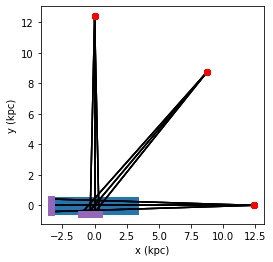

In [5]:
# controlling the orientation with domain_theta_rad
def my_plot(ds, axis = 'z', domain_theta_l = [0, np.pi/4, np.pi/2],
            domain_phi_l = [0, np.pi/4, np.pi/2], axes_unit = 'kpc'):
    fig,ax = plt.subplots(1,1, figsize = (4,4))

    for domain_theta_rad in domain_theta_l:
        for domain_phi_rad in domain_phi_l:
            ray_col = perspective_ray_grid(
                ds = ds, sky_latitude_ref_deg = 0.0, observer_distance = 12.4 * unyt.kpc,
                sky_delta_latitude_arr_deg = np.array([-1.5,0.0, 1.5]), 
                sky_longitude_arr_deg = np.array([-1.5,0.0, 1.5]),
                domain_theta_rad = domain_theta_rad, domain_phi_rad = domain_phi_rad)
            plot_projected_ray_path(ax, axis, ray_col, axes_unit = 'kpc', ds = ds,
                                    plot_start_fmt = 'ro', plot_stop_fmt = 'C4s',
                                    label_axis = True, exclude_intersectionless = True)
    # plot domain region:
    l,r = ds.domain_left_edge.to(axes_unit).v, ds.domain_right_edge.to(axes_unit).v
    imx, imy = {'z': (0,1), 'y' : (2,0), 'x' : (1,0)}[axis]
    ax.fill_between(x = [l[imx], r[imx]], y1 = l[imy], y2 = r[imy], color = 'C0')
    return ax

my_plot(ds, 'z', domain_theta_l = [np.pi/2], domain_phi_l = [0, np.pi/4, np.pi/2]);

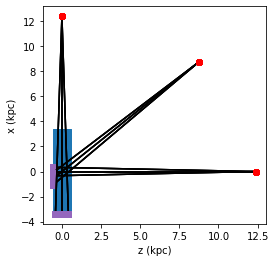

In [6]:
my_plot(ds, 'y', domain_theta_l = [0, np.pi/4, np.pi/2], domain_phi_l = [0]);

Lots of work relating mock-observations operate in the regime where the size of the simulated object is much smaller than the distance to the object. In those cases, it's a great approximation to construct a grid of parallel rays.

While I suspect we could get away with drawing parallel rays, I think HVCs like the Smith Cloud may lie in a regime where this could hypothetically produce problems. This is illustrated by the following images. These images show paths traced by rays (using parallel and perspective tracing) with respect to the simulation, when viewed along the x-, y-, and z-axes. The red dots show where each of the rays originate.

**Disclaimer:** I estimated the ray-spacing for the parallel-rays using the small-angle approximation: $\delta \approx (diameter/distance) {\rm radians}$. This may make the parallel-ray case look worse than it is. Nevertheless, I think the perspective ray images may suggest that the perspective ray-tracing could be important (I think they may be especially relevant when considering velocity-structure-functions or velocity-channel-analysis).

Parsing Hierarchy: 100%|██████████| 256/256 [00:00<00:00, 3074.96it/s]
yt : [INFO     ] 2023-10-31 13:51:51,841 Projection completed
yt : [INFO     ] 2023-10-31 13:51:51,842 xlim = -60.000000 60.000000
yt : [INFO     ] 2023-10-31 13:51:51,842 ylim = -10.000000 10.000000
yt : [INFO     ] 2023-10-31 13:51:51,843 xlim = -60.000000 60.000000
yt : [INFO     ] 2023-10-31 13:51:51,844 ylim = -10.000000 10.000000
yt : [INFO     ] 2023-10-31 13:51:51,854 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-31 13:51:54,198 Projection completed
yt : [INFO     ] 2023-10-31 13:51:54,199 xlim = -60.000000 60.000000
yt : [INFO     ] 2023-10-31 13:51:54,199 ylim = -10.000000 10.000000
yt : [INFO     ] 2023-10-31 13:51:54,200 xlim = -60.000000 60.000000
yt : [INFO     ] 2023-10-31 13:51:54,200 ylim = -10.000000 10.000000
yt : [INFO     ] 2023-10-31 13:51:54,210 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800


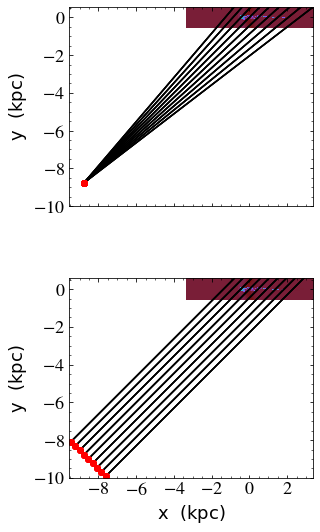

In [7]:
def mk_compare_plot(ds,domain_theta_rad = np.pi/2,
                    domain_phi_rad = 5*np.pi/4,
                    full_proj = True,
                    my_sky_delta_latitude_arr_deg = np.array([-1.5,0.0,1.5]),
                    my_sky_longitude_arr_deg = np.array([-7.5, -6, -4.5,-3.0,-1.5,0.0,
                                                         1.5,3.0,4.5]),
                    exclude_intersectionless = True,
                    observer_distance = 12.4*unyt.kpc,
                    compare_axes = []):
    

    ray_col_parallel = parallel_ray_grid(
        ds = ds,
        delta_im_x = unyt.unyt_array(my_sky_longitude_arr_deg, 'degree'),
        delta_im_y = unyt.unyt_array(my_sky_delta_latitude_arr_deg, 'degree'),
        domain_theta_rad = domain_theta_rad,
        domain_phi_rad = domain_phi_rad,
        observer_distance = observer_distance
    )
    
    ray_col_perspective = perspective_ray_grid(
        ds = ds, sky_latitude_ref_deg = 0.0,
        observer_distance = observer_distance,
        sky_delta_latitude_arr_deg = my_sky_delta_latitude_arr_deg,
        sky_longitude_arr_deg = my_sky_longitude_arr_deg,
        domain_theta_rad = domain_theta_rad, domain_phi_rad = domain_phi_rad)

    assert len(compare_axes) > 0 and len(set(compare_axes)) == len(compare_axes)

    preset = {'x' : dict(nrows=2, ncols=1, figsize = (8,4)),
              'y' : dict(nrows=1, ncols=2, figsize = (4,8)),
              'z' : dict(nrows=2, ncols=1, figsize = (4,8))}
    for axis in compare_axes:
        assert axis in 'xyz'
        tmp = preset[axis]
        fig = plt.figure(figsize = tmp['figsize'])
        grid = AxesGrid(fig,(0.075, 0.075, 0.85, 0.85),
                        nrows_ncols=(tmp['nrows'], tmp['ncols']),
                        axes_pad=1.0, label_mode="L", share_all=True)

        for i,ray_col in enumerate([ray_col_perspective, ray_col_parallel]):
            plot_ray_and_projection(
                ds, fig, grid[i].axes, axis, ray_collection = ray_col,
                axes_unit = 'kpc', full_proj = full_proj,
                exclude_intersectionless = exclude_intersectionless)

mk_compare_plot(ds, compare_axes = 'z',
                exclude_intersectionless = True)

# Calling the radiative Transfer Solver

In [8]:
from gasimage import (
    default_spin_flip_props,
    optically_thin_ppv,
    convert_intensity_to_Tb,
    SnapDatasetInitializer,
)

# come up with velocity channels
v_channels = np.arange(-170,180,0.736125)*yt.units.km/yt.units.s

# come up with spacing of rays (to get a result quickly, we coarsen the 
# spacing a little bit)
_DEG_SPACING = 0.0166667 * 3 # 3 times more coarse than my target...
my_sky_delta_latitude_arr_deg = np.arange(-1.5, 1.51, _DEG_SPACING)
my_sky_longitude_arr_deg = np.arange(-3, 7.51, _DEG_SPACING)

ray_collection = perspective_ray_grid(
    observer_distance = 12.4*unyt.kpc,
    domain_theta_rad = np.pi/2, domain_phi_rad = np.pi/2,
    sky_latitude_ref_deg = 0.0,
    sky_delta_latitude_arr_deg = my_sky_delta_latitude_arr_deg,
    sky_longitude_arr_deg = my_sky_longitude_arr_deg,
    ds = ds,
)

# perform radiative transfer and produce a ppv cube
ppv = optically_thin_ppv(
    v_channels = v_channels,
    ray_collection = ray_collection, 
    ds = SnapDatasetInitializer(fname = _SIM_FNAME,
                                setup_func = define_derived_fields),
    ndens_HI_n1state = ('gas', 'H_p0_number_density'),
    pool = None # more on this later
)

# convert the ppv cube so its now in units of brightness temperature
ppv_Tb = convert_intensity_to_Tb(ppv, v_channels)

yt : [INFO     ] 2023-10-31 13:51:55,473 Parameters: current_time              = 7.5
yt : [INFO     ] 2023-10-31 13:51:55,474 Parameters: domain_dimensions         = [960 160 160]
yt : [INFO     ] 2023-10-31 13:51:55,476 Parameters: domain_left_edge          = [-60. -10. -10.]
yt : [INFO     ] 2023-10-31 13:51:55,478 Parameters: domain_right_edge         = [60. 10. 10.]
yt : [INFO     ] 2023-10-31 13:51:55,478 Parameters: cosmological_simulation   = 0
Parsing Hierarchy: 100%|██████████| 256/256 [00:00<00:00, 7752.42it/s]


The ('gas','temperature') doesn't exist. So we're defining it using the ('enzoe','temperature') field
Constructing RayGridAssignments
begin raycasting -- start time: 13:51:57.047407
grid_index =  96  num_rays =  138
grid_index =  97  num_rays =  575
grid_index =  98  num_rays =  598
grid_index =  99  num_rays =  138
grid_index =  100  num_rays =  110
grid_index =  101  num_rays =  571
grid_index =  102  num_rays =  593
grid_index =  103  num_rays =  110
grid_index =  104  num_rays =  84
grid_index =  105  num_rays =  546
grid_index =  106  num_rays =  567
grid_index =  107  num_rays =  84
grid_index =  108  num_rays =  84
grid_index =  109  num_rays =  566
grid_index =  110  num_rays =  587
grid_index =  111  num_rays =  84
grid_index =  112  num_rays =  227
grid_index =  113  num_rays =  950
grid_index =  114  num_rays =  988
grid_index =  115  num_rays =  227
grid_index =  116  num_rays =  195
grid_index =  117  num_rays =  1014
grid_index =  118  num_rays =  1053
grid_index =  119  

In [9]:
# we can write the ppv-cube to a fits file and view it with ds9
from gasimage.utils.fits import write_to_fits

write_to_fits(fname = './tutorial_result.fits', ppv_Tb = ppv_Tb,
              sky_longitude_arr_deg = my_sky_longitude_arr_deg,
              sky_delta_latitude_arr_deg = my_sky_delta_latitude_arr_deg,
              sky_latitude_ref_deg = 0.0,
              v_channels = v_channels,
              rest_freq = default_spin_flip_props().freq_quantity,
              writeto_kwargs = {'overwrite' : True}) # overwrite the file if it already exists

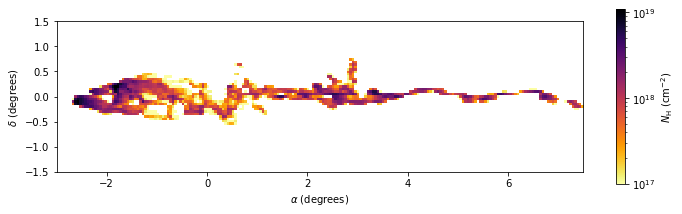

In [10]:
# for the sake of visualizing the result, here we plot a moment0-map
# (which effectively gives column density of Hydrogen)
#
# NOTE: to make comparisons with observations, we need to degrade 
#       the image. I've got some scripts that can help you do that!

from matplotlib.colors import LogNorm

def crude_moment0_map(ppv_Tb, v_channels):
    # this comes from Yong's script. I wasn't super careful here copying over...

    k2cm2 = 1.823e18  # from K km/s to cm-2. Can be found in the ISM book, Draine 2004
    delv = np.mean(np.diff(v_channels))
    colden = (ppv_Tb*delv).sum(0)
    return (colden.to('K*km/s').v *k2cm2) / unyt.cm**2

def plot_crud_moment0(ppv_Tb, v_channels, vmin = None, vmax = None):

    moment0 = crude_moment0_map(ppv_Tb, v_channels)
    fig,ax = plt.subplots(1,1, figsize = (10,3))
    im = ax.imshow(
        moment0.v, norm = LogNorm(vmin = vmin, vmax = vmax),
        extent = [my_sky_longitude_arr_deg.min(),
                  my_sky_longitude_arr_deg.max(),
                  my_sky_delta_latitude_arr_deg.min(),
                  my_sky_delta_latitude_arr_deg.max()],
        interpolation = 'none',
        cmap = 'inferno_r'
    )

    plt.colorbar(im, ax = ax,
                 label = r'$N_{\rm H}$ (${\rm cm^{-2}}$)')
    ax.set_xlabel(r'$\alpha$ (degrees)')
    ax.set_ylabel(r'$\delta$ (degrees)')
    fig.tight_layout()
plot_crud_moment0(ppv_Tb, v_channels, vmin = 1e17)

### Comparison to yt-projection
For the sake of comparison, here's the projection of the mass-density along the y-axis



yt : [INFO     ] 2023-10-31 13:52:21,614 Projection completed
yt : [INFO     ] 2023-10-31 13:52:21,615 xlim = -0.563800 0.563800
yt : [INFO     ] 2023-10-31 13:52:21,615 ylim = -1.000000 3.000000
yt : [INFO     ] 2023-10-31 13:52:21,617 xlim = -10.000000 10.000000
yt : [INFO     ] 2023-10-31 13:52:21,617 ylim = -17.736786 53.210358
yt : [INFO     ] 2023-10-31 13:52:21,632 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



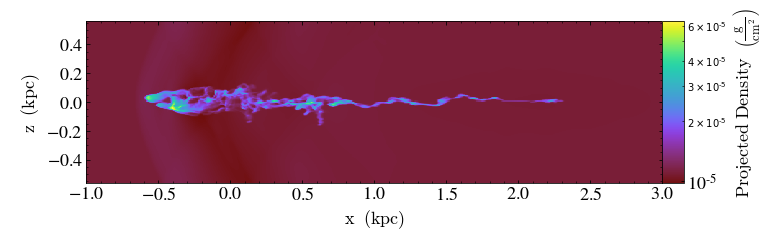

In [11]:
proj = yt.ProjectionPlot(
    ds,'y',("gas", "density"), 
    origin = 'center-domain',
    center = ds.arr([1.0, 0.0, 0.0], 'kpc'), #(x,y,z)
    width = ((float(ds.domain_width[1].to('kpc').v), 'kpc'), # initial image-y
             (4.0, 'kpc')), # initial image-y
)
proj.swap_axes()
proj

# Example with Multiprocessing-Parallelism

Here's an example of running this program using multiprocessing-parallelism. It will also support MPI parallelism (I may need to work out a few bugs)

This is mostly here to demonstrate that its possible. However, it is a little idiosyncratic and I want to write up more of an explanation for how it works.

**NOTE:** Parallelism will be more efficient for higher resolution simulations

In [12]:
from schwimmbad import MultiPool

_DEG_SPACING = 0.0166667
my_sky_delta_latitude_arr_deg = np.arange(-1.5, 1.51, _DEG_SPACING)
my_sky_longitude_arr_deg = np.arange(-3, 7.51, _DEG_SPACING)

ray_collection = perspective_ray_grid(
    observer_distance = 12.4*unyt.kpc,
    domain_theta_rad = np.pi/2, domain_phi_rad = np.pi/2,
    sky_latitude_ref_deg = 0.0,
    sky_delta_latitude_arr_deg = my_sky_delta_latitude_arr_deg,
    sky_longitude_arr_deg = my_sky_longitude_arr_deg,
    ds = ds,
)

with MultiPool(processes = 4) as pool:
    ppv_perspectiveALT = optically_thin_ppv(
        v_channels = v_channels,
        ray_collection = ray_collection, 
        ds = SnapDatasetInitializer(fname = _SIM_FNAME,
                                    setup_func = define_derived_fields),
        ndens_HI_n1state = ('gas', 'H_p0_number_density'),
        pool = pool
    )

# convert the ppv cube so its now in units of brightness temperature
ppv_Tb_perspectiveALT = convert_intensity_to_Tb(ppv_perspectiveALT, v_channels)

write_to_fits(fname = './tutorial_result_finer_pixes.fits', ppv_Tb = ppv_Tb_perspectiveALT,
              sky_longitude_arr_deg = my_sky_longitude_arr_deg,
              sky_delta_latitude_arr_deg = my_sky_delta_latitude_arr_deg,
              sky_latitude_ref_deg = 0.0,
              v_channels = v_channels,
              rest_freq = default_spin_flip_props().freq_quantity,
              writeto_kwargs = {'overwrite' : True}) # overwrite the file if it already exists

Constructing RayGridAssignments
begin raycasting -- start time: 13:52:33.440564
grid_index =  96  num_rays =  1088
grid_index =  97  num_rays =  5166
grid_index =  98  num_rays =  5234
grid_index =  99  num_rays =  1088
grid_index =  100  num_rays =  924
grid_index =  101  num_rays =  5144
grid_index =  102  num_rays =  5210
grid_index =  103  num_rays =  924
grid_index =  104  num_rays =  756
grid_index =  105  num_rays =  4976
grid_index =  106  num_rays =  5039
grid_index =  107  num_rays =  756
grid_index =  108  num_rays =  671
grid_index =  109  num_rays =  4938
grid_index =  110  num_rays =  4999
grid_index =  111  num_rays =  671
grid_index =  112  num_rays =  1822
grid_index =  113  num_rays =  8664
grid_index =  114  num_rays =  8778
grid_index =  115  num_rays =  1822
grid_index =  116  num_rays =  1636
grid_index =  117  num_rays =  9126
grid_index =  118  num_rays =  9243
grid_index =  119  num_rays =  1636
grid_index =  120  num_rays =  1427
grid_index =  121  num_rays = 

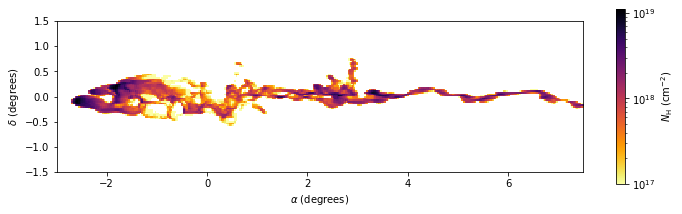

In [13]:
plot_crud_moment0(ppv_Tb_perspectiveALT, v_channels, vmin = 1e17)

# Example with a parallel_ray_grid

Finally, here's an example using a parallel-ray-grid.

Note, there are a few optimizations that can be made here since we know that the direction of every ray is parallel to one-another...

In [14]:
from schwimmbad import MultiPool

# come up with spacing of rays (to get a result quickly, we coarsen the 
# spacing a little bit)
_DEG_SPACING = 0.0166667
my_sky_delta_latitude_arr_deg = np.arange(-1.5, 1.51, _DEG_SPACING)
my_sky_longitude_arr_deg = np.arange(-3, 7.51, _DEG_SPACING)

ray_collection = parallel_ray_grid(
    delta_im_x = unyt.unyt_array(my_sky_longitude_arr_deg, 'degree'),
    delta_im_y = unyt.unyt_array(my_sky_delta_latitude_arr_deg, 'degree'),
    ds = ds, observer_distance = 12.4*unyt.kpc,
    domain_theta_rad = np.pi/2, domain_phi_rad = np.pi/2,
)


with MultiPool(processes = 4) as pool:
    ppv_parallelRays = optically_thin_ppv(
        v_channels = v_channels,
        ray_collection = ray_collection, 
        ds = SnapDatasetInitializer(fname = _SIM_FNAME,
                                    setup_func = define_derived_fields),
        ndens_HI_n1state = ('gas', 'H_p0_number_density'),
        pool = pool
    )
    
# convert the ppv cube so its now in units of brightness temperature
ppv_parallelRays_Tb = convert_intensity_to_Tb(ppv_parallelRays, v_channels)

Constructing RayGridAssignments
begin raycasting -- start time: 13:53:36.104308
grid_index =  96  num_rays =  756
grid_index =  97  num_rays =  4914
grid_index =  98  num_rays =  4977
grid_index =  99  num_rays =  756
grid_index =  100  num_rays =  756
grid_index =  101  num_rays =  4914
grid_index =  102  num_rays =  4977
grid_index =  103  num_rays =  756
grid_index =  104  num_rays =  756
grid_index =  105  num_rays =  4914
grid_index =  106  num_rays =  4977
grid_index =  107  num_rays =  756
grid_index =  108  num_rays =  756
grid_index =  109  num_rays =  4914
grid_index =  110  num_rays =  4977
grid_index =  111  num_rays =  756
grid_index =  112  num_rays =  1404
grid_index =  113  num_rays =  9126
grid_index =  114  num_rays =  9243
grid_index =  115  num_rays =  1404
grid_index =  116  num_rays =  1404
grid_index =  117  num_rays =  9126
grid_index =  118  num_rays =  9243
grid_index =  119  num_rays =  1404
grid_index =  120  num_rays =  1404
grid_index =  121  num_rays =  9

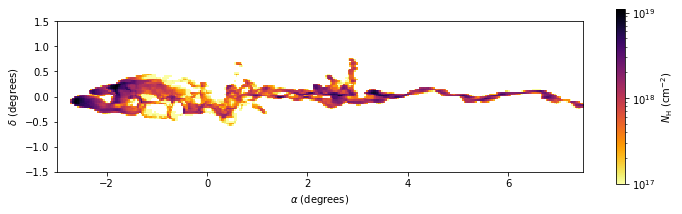

In [15]:
plot_crud_moment0(ppv_parallelRays_Tb, v_channels, vmin = 1e17)